# Восстановление золота из руды

# Описание данных

Данные находятся в трёх файлах:
- gold_industry_train.csv обучающая выборка;
- gold_industry_test.csv тестовая выборка;
- gold_industry_full.csv исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

У нас сырые данные - их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверим по инструкции их на корректность.

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

**Описание данных:**

*Технологический процесс*
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant 
    - Xanthate — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

*Параметры этапов*
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


**Наименование признаков**<br>
Наименование признаков должно быть такое: <br>
[этап].[тип_параметра].[название_параметра]<br>
Пример: rougher.input.feed_ag<br>

Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики


## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV, cross_val_score
from tqdm import tqdm
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
gold_train = pd.read_csv('/datasets/gold_industry_train.csv', index_col='date')
gold_test = pd.read_csv('/datasets/gold_industry_test.csv', index_col='date')
gold_full = pd.read_csv('/datasets/gold_industry_full.csv', index_col='date') #прочитаем файлы

In [3]:
def discover(data):
    display(data.describe())
    display(f'Количество пропусков:{data.isna().sum()}')
    display(f'Количество дубликатов:{data.duplicated().sum()}')

In [4]:
print('Тренировочная выборка')
discover(gold_train)

Тренировочная выборка


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


'Количество пропусков:rougher.input.feed_au       0\nrougher.input.feed_ag       0\nrougher.input.feed_pb      72\nrougher.input.feed_sol     77\nrougher.input.feed_rate     7\n                           ..\nfinal.output.recovery       0\nfinal.output.tail_au        0\nfinal.output.tail_ag        1\nfinal.output.tail_pb       75\nfinal.output.tail_sol       5\nLength: 86, dtype: int64'

'Количество дубликатов:0'

In [5]:
print('Тестовая выборка')
discover(gold_test)

Тестовая выборка


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


'Количество пропусков:rougher.input.feed_au                           0\nrougher.input.feed_ag                           0\nrougher.input.feed_pb                          28\nrougher.input.feed_sol                         22\nrougher.input.feed_rate                         4\nrougher.input.feed_size                        44\nrougher.input.floatbank10_sulfate               3\nrougher.input.floatbank10_xanthate              1\nrougher.state.floatbank10_a_air                 1\nrougher.state.floatbank10_a_level               1\nrougher.state.floatbank10_b_air                 1\nrougher.state.floatbank10_b_level               1\nrougher.state.floatbank10_c_air                 1\nrougher.state.floatbank10_c_level               1\nrougher.state.floatbank10_d_air                 0\nrougher.state.floatbank10_d_level               0\nrougher.state.floatbank10_e_air                 7\nrougher.state.floatbank10_e_level               0\nrougher.state.floatbank10_f_air                 0\nrougher.s

'Количество дубликатов:0'

In [6]:
print('Исходные данные')
discover(gold_full)

Исходные данные


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


'Количество пропусков:rougher.input.feed_au        0\nrougher.input.feed_ag        0\nrougher.input.feed_pb      100\nrougher.input.feed_sol      99\nrougher.input.feed_rate     11\n                          ... \nfinal.output.recovery        0\nfinal.output.tail_au         0\nfinal.output.tail_ag         1\nfinal.output.tail_pb       101\nfinal.output.tail_sol        6\nLength: 86, dtype: int64'

'Количество дубликатов:0'

In [7]:
gold_full.info() #посмотрим названия всех столбцов для дальнейшей работы

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               19439 non-null  float64
 1   rougher.input.feed_ag                               19439 non-null  float64
 2   rougher.input.feed_pb                               19339 non-null  float64
 3   rougher.input.feed_sol                              19340 non-null  float64
 4   rougher.input.feed_rate                             19428 non-null  float64
 5   rougher.input.feed_size                             19294 non-null  float64
 6   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 7   rougher.input.floatbank10_xanthate                  19431 non-null  float64
 8   rougher.state.floatbank10_a_air                  

In [8]:
gold_train.shape, gold_test.shape, gold_full.shape
#посмотрим размер датасетов

((14579, 86), (4860, 52), (19439, 86))

В тестовой выборке 52 признака, в то время как в тренировочной 86. Во всех выборках отсутствуют данные.

### Расчет эффективности обогащения 

 **Проверим расчет эффективности обогащения на обучающей выборке**

- C — доля золота в концентрате после флотации/очистки
- F — доля золота в сырье/концентрате до флотации/очистки
- T — доля золота в отвальных хвостах после флотации/очистки

In [9]:
C = gold_train['rougher.output.concentrate_au']
F = gold_train['rougher.input.feed_au']
T = gold_train['rougher.output.tail_au']

recovery = ((C * (F - T)) / (F * (C - T))) * 100
recovery.describe()

count    14579.000000
mean        82.521200
std         15.797521
min         -0.000000
25%         80.558542
50%         85.946497
75%         89.960375
max        100.000000
dtype: float64

### MAE

**Найдем МАЕ между нашим расчетом и значением признака rougher.output.recovery**

In [10]:
mae_recovery = mean_absolute_error(gold_train['rougher.output.recovery'], recovery)
print('MAE', mae_recovery)

MAE 9.83758577644259e-15


Средняя абсолютная ошибка между расчетом и значением признака rougher.output.recovery незначительна, значение верно.

### Анализ признаков

**Проанализируем признаки, недоступные в тестовой выборке**

In [11]:
def lost(list1, list2):
    return set(list1.columns) - set(list2.columns)
lost_features = lost(gold_train, gold_test)
gold_train[lost_features].info() #посмотрим тип и параметры

<class 'pandas.core.frame.DataFrame'>
Index: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   primary_cleaner.output.tail_sol                     14534 non-null  float64
 1   secondary_cleaner.output.tail_pb                    14575 non-null  float64
 2   rougher.calculation.floatbank10_sulfate_to_au_feed  14578 non-null  float64
 3   final.output.recovery                               14579 non-null  float64
 4   primary_cleaner.output.tail_au                      14579 non-null  float64
 5   primary_cleaner.output.concentrate_pb               14491 non-null  float64
 6   primary_cleaner.output.concentrate_sol              14314 non-null  float64
 7   final.output.tail_ag                                14578 non-null  float64
 8   rougher.output.concentrate_ag                    

Недоступные признаки в тестовой выборке типа float.
Всего 34 признака, включающие параметры продукта и расчетные. 

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. 
Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей.

In [12]:
gold_test = gold_test.merge(gold_full[['final.output.recovery', 'rougher.output.recovery']], on='date', how='left')
gold_test.shape #добавим в тестовую выборку целевые признаки из исходных данных по совпадению даты

(4860, 54)

In [13]:
gold_train = gold_train.fillna(method='bfill')
gold_test = gold_test.fillna(method='bfill') #заполним пропуски соседними параметрами, которые часто похожи (из описания задачи)

In [14]:
gold_train.isna().sum().sum(), gold_test.isna().sum().sum() #проверим пропуски

(0, 0)

<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px">
В тестовой выборке 52 признака, в то время как в тренировочной 86. Во всех выборках отсутствуют данные.

Средняя абсолютная ошибка между расчетом и значением признака rougher.output.recovery незначительна, значение верно.
MAE 9.83758577644259e-15

Недоступные признаки в тестовой выборке типа float. Всего 34 признака, включающие параметры продукта и расчетные.

Удалили строки с пустыми значениями целевых признаков в тренировочной и тестовой выборках. 
Заполнили пропуски соседними параметрами, которые часто похожи (из описания задачи)

## Анализ данных

### Концентрация металлов

**Посмотрим, как меняется концентрация металлов:**
- AU золото
- AG серебро
- PB свинец

на различных этапах: 
- в сырье rougher.input.feed
- в черновом концентрате rougher.output.concentrate
- в концентрате после первой очистки primary_cleaner.output.concentrate
- в финальном концентрате final.output.concentrate                

In [15]:
METALS = ['au', 'ag', 'pb']

In [16]:
PHASES = ['rougher.input.feed','rougher.output.concentrate','primary_cleaner.output.concentrate','final.output.concentrate']

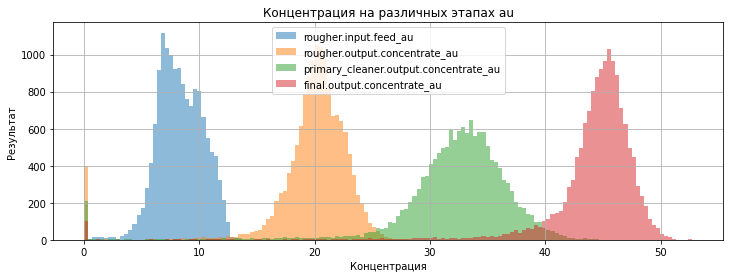

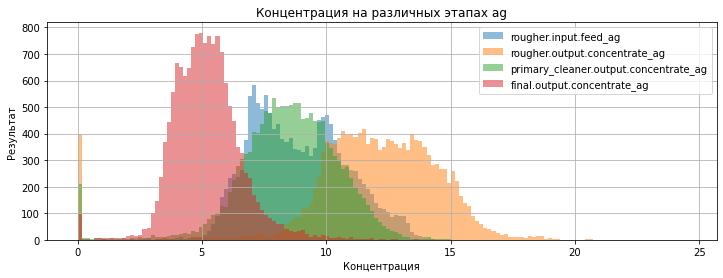

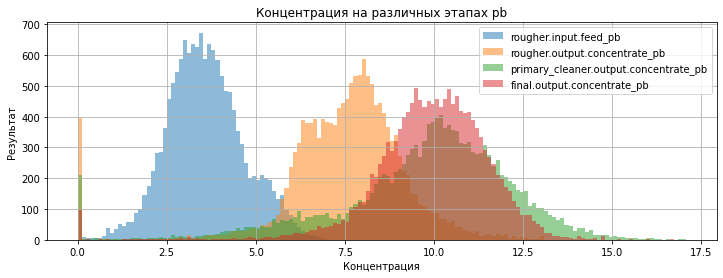

In [17]:
for metal in METALS:
    index = ['{}_{}'.format(x, metal) for x in PHASES]
    
    gold_train[index].plot(
        title = 'Концентрация на различных этапах {}'.format(metal.lower()),
        kind = 'hist', 
        bins = 150, 
        grid = True, 
        legend = True,
        figsize = (12, 4),
        alpha = 0.5,
    ).set(xlabel = 'Концентрация', ylabel = 'Результат')
    
    plt.show()

Посмотрим средние значения

In [18]:
for metal in METALS:
    index = ['{}_{}'.format(x, metal) for x in PHASES]
    display(gold_train[index].mean().round(2))

rougher.input.feed_au                     8.35
rougher.output.concentrate_au            19.72
primary_cleaner.output.concentrate_au    32.01
final.output.concentrate_au              43.98
dtype: float64

rougher.input.feed_ag                     8.88
rougher.output.concentrate_ag            11.94
primary_cleaner.output.concentrate_ag     8.47
final.output.concentrate_ag               5.19
dtype: float64

rougher.input.feed_pb                    3.59
rougher.output.concentrate_pb            7.50
primary_cleaner.output.concentrate_pb    9.73
final.output.concentrate_pb              9.92
dtype: float64

<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px"> 
Наилучший показатель у золота - концентрация растет с каждым этапом, в финальном более 5 раз от сырья. <br>
Концентрация серебра начала снижаться после чернового концентрата, уменьшилась на треть.  <br>
После первой очистки повысилась концентрация свинца, но почти не изменялись в финальном. <br>
У каждого металла свой характер.

*Золото*
- в сырье 8.35
- в черновом концентрате 19.72
- в концентрате после первой очистки 32.01
- в финальном концентрате 43.98

*Серебро*
- в сырье 8.88
- в черновом концентрате 11.94
- в концентрате после первой очистки 8.47
- в финальном концентрате 5.19

*Свинец*
- в сырье 3.59
- в черновом концентрате 7.50
- в концентрате после первой очистки 9.73
- в финальном концентрате 9.92


In [19]:
def filtered(gold):
    
    gold = gold.drop(gold[gold['rougher.input.feed_au'] < 1].index, axis = 0)
    gold = gold.drop(gold[gold['rougher.input.feed_ag'] < 1].index, axis = 0)
    gold = gold.drop(gold[gold['rougher.input.feed_pb'] < 1].index, axis = 0)

    gold = gold.drop(gold[gold['rougher.output.concentrate_au'] < 1].index, axis = 0)
    gold = gold.drop(gold[gold['rougher.output.concentrate_ag'] < 1].index, axis = 0)
    gold = gold.drop(gold[gold['rougher.output.concentrate_pb'] < 1].index, axis = 0)
    
    gold = gold.drop(gold[gold['primary_cleaner.output.concentrate_au'] < 1].index, axis = 0)
    gold = gold.drop(gold[gold['primary_cleaner.output.concentrate_ag'] < 1].index, axis = 0)
    gold = gold.drop(gold[gold['primary_cleaner.output.concentrate_pb'] < 1].index, axis = 0)

    gold = gold.drop(gold[gold['final.output.concentrate_au'] < 1].index, axis = 0)
    gold = gold.drop(gold[gold['final.output.concentrate_ag'] < 1].index, axis = 0)
    gold = gold.drop(gold[gold['final.output.concentrate_pb'] < 1].index, axis = 0)
    
    return gold

In [20]:
gold_train_n = filtered(gold_train)

### Распределение гранул

**Сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках.**

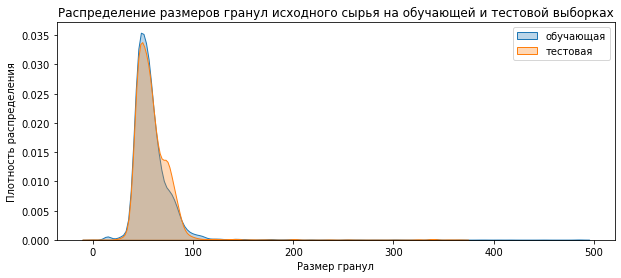

Средний размер гранул на обучающей выборке 58.79
Средний размер гранул на тестовой выборке 59.08


In [21]:
plt.figure(figsize=(10, 4))
sns.kdeplot(gold_train_n['rougher.input.feed_size'],label='обучающая', alpha=0.3, shade=True)
sns.kdeplot(gold_test['rougher.input.feed_size'],label='тестовая', alpha=0.3, shade=True)
plt.title('Распределение размеров гранул исходного сырья на обучающей и тестовой выборках')
plt.xlabel('Размер гранул')
plt.ylabel('Плотность распределения')
plt.legend(loc='upper right')
plt.show()

g_train = gold_train_n['rougher.input.feed_size']
g_test = gold_test['rougher.input.feed_size']

print('Средний размер гранул на обучающей выборке', g_train.mean().round(2))
print('Средний размер гранул на тестовой выборке', g_test.mean().round(2))

Распределения размеров похожи, оценка модели будет правильной.

### Суммарная концентрация металлов

**Исследуем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.**

In [22]:
concentration_sum = pd.DataFrame()

concentration_sum['input.feed.sum'] = gold_train_n['rougher.input.feed_ag'] + gold_train_n['rougher.input.feed_au'] \
+ gold_train_n['rougher.input.feed_pb']
#в сырье

concentration_sum['output.concentrate.sum'] = gold_train_n['rougher.output.concentrate_ag'] + gold_train_n['rougher.output.concentrate_au'] \
+ gold_train['rougher.output.concentrate_pb']
# в черновом концентрате

concentration_sum['primary.cleaner.sum'] = gold_train_n['primary_cleaner.output.concentrate_ag'] + \
gold_train_n['primary_cleaner.output.concentrate_au'] + gold_train_n['primary_cleaner.output.concentrate_pb'] 
#в концентрате после первой очистки

concentration_sum['final.sum'] = gold_train_n['final.output.concentrate_ag'] + gold_train_n['final.output.concentrate_au'] + \
gold_train_n['final.output.concentrate_pb'] 
#в финальном концентрате

concentration_sum.describe()

,input.feed.sum,output.concentrate.sum,primary.cleaner.sum,final.sum
count,13752.000000,13752.000000,13752.000000,13752.000000
mean,20.904595,40.307587,51.039631,59.580222
std,4.345553,3.776404,4.829354,3.914133
min,5.394392,6.569552,6.518568,9.231520
25%,17.475313,38.634997,50.168945,59.289957
50%,20.450714,40.486299,51.909867,60.279473
75%,23.980289,42.504450,53.328804,61.055966
max,33.324268,55.568687,60.106566,64.968881


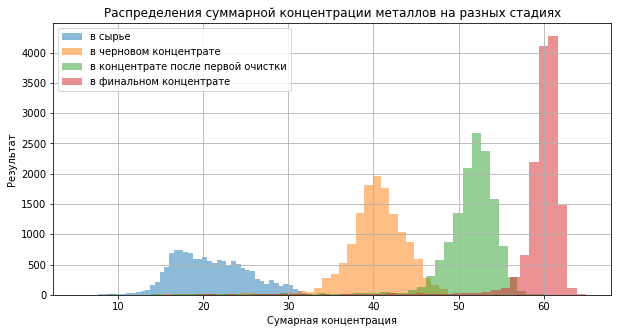

In [23]:
plt.figure(figsize = (10, 5))
concentration_sum['input.feed.sum'].hist(label='в сырье',bins=50, alpha=0.5)
concentration_sum['output.concentrate.sum'].hist(label='в черновом концентрате', bins=50, alpha=0.5)
concentration_sum['primary.cleaner.sum'].hist(label='в концентрате после первой очистки', bins=50, alpha=0.5)
concentration_sum['final.sum'].hist(label='в финальном концентрате', bins=50, alpha=0.5)
plt.title('Распределения суммарной концентрации металлов на разных стадиях')
plt.xlabel('Сумарная концентрация')
plt.ylabel('Результат')
plt.legend(loc='upper left')
plt.show() #построим гистограмму

Суммарная концентрация металлов растет в черновом концентрате и после первой очистки.

## Модель

### sMAPE

**Для решения задачи нужна новая метрика качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»)**

In [24]:
def smape(target,predicted):
    a = np.abs(target - predicted)
    b = (np.abs(target) + np.abs(predicted)) / 2 
    return 1 / len(target) * np.sum(a / b) * 100 

In [25]:
def final_smape(target, predicted):
    target_rougher = target['rougher.output.recovery']
    target_final = target['final.output.recovery']
    predicted_rougher = predicted[:, 0]
    predicted_final = predicted[:, 1]
    return 0.25 * smape(target_rougher, predicted_rougher) + 0.75 * smape(target_final , predicted_final)

### Обучение моделей

Посмотрим признаки из обучающей выборки, которые отсутствуют в тестовой и удалим их.

In [26]:
lost_features = lost(gold_train_n, gold_test)
gold_train = gold_train_n.drop(lost_features, axis=1) 
gold_train.shape, gold_test.shape #посмотрим на размер выборок

((13752, 54), (4860, 54))

In [27]:
scorer = make_scorer(final_smape, greater_is_better=False) #метрика для кросс-валидации

**Признаки и целевые признаки для моделей**

In [28]:
TARGETS = ['rougher.output.recovery', 'final.output.recovery'] 
#эффективность обогащения чернового концентрата и финального концентратов

In [29]:
features_train = gold_train.drop(TARGETS, axis='columns')
target_train = gold_train[TARGETS]
features_test = gold_test.drop(TARGETS, axis='columns')
target_test = gold_test[TARGETS]

**Случайный лес**

In [30]:
%%time
param_grid = {'max_depth':[i for i in range(2, 7)],'n_estimators':[i for i in range(2, 13, 3)]}
model_rfr = RandomForestRegressor(random_state=12345)
grid = GridSearchCV(model_rfr, param_grid, cv=5, scoring=scorer)
grid.fit(features_train, target_train)
print('Лучшее значение sMAPE для модели случайного леса: {} при гиперпараметре: {}'.format(-grid.best_score_, grid.best_params_))

Лучшее значение sMAPE для модели случайного леса: 8.256347236287287 при гиперпараметре: {'max_depth': 3, 'n_estimators': 2}
CPU times: user 1min 31s, sys: 98.2 ms, total: 1min 31s
Wall time: 1min 31s


**Линейная регрессия**

In [31]:
model_lr = LinearRegression()
cross = cross_val_score(model_lr, features_train, target_train, cv=3, scoring=scorer).mean()
model_lr.fit(features_train, target_train)
print('Лучшее значение sMAPE для модели линейной регрессии:', -cross)

Лучшее значение sMAPE для модели линейной регрессии: 10.263344857083196


Показатель sMAPE модели случайного леса лучше, лучший результат при количестве деревьев 2 и глубине 3.

### Тестирование модели

**Проверим модель случайного леса на тестовой выборке**

In [32]:
model = RandomForestRegressor(max_depth=3, n_estimators=11, random_state=12345) 
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print('Значение sMAPE на тестовой выборке:', final_smape(target_test, predicted_test))

Значение sMAPE на тестовой выборке: 7.448225118423632


**Проверим модель на адекватность**

In [33]:
dummy_regr = DummyRegressor(strategy = 'mean')
dummy_regr.fit(features_train, target_train)
predicted_dummy_test = dummy_regr.predict(features_test)
print('Значение sMAPE константной модели', final_smape(target_test,predicted_dummy_test))

Значение sMAPE константной модели 8.454883330567553


<div class="alert-info" style="padding: 20px; border-radius: 10px">
    Проанализировали <b>концентрацию металлов</b> на различный этапах.
Наилучший показатель у золота - концентрация растет с каждым этапом, в финальном более 5 раз от сырья.
Концентрация серебра начала снижаться после чернового концентрата, уменьшилась на треть.
После первой очистки повысилась концентрация свинца, но почти не изменялись в финальном.<br>
    
*Золото*
- в сырье 8.35
- в черновом концентрате 19.72
- в концентрате после первой очистки 32.01
- в финальном концентрате 43.98

*Серебро*
- в сырье 8.88
- в черновом концентрате 11.94
- в концентрате после первой очистки 8.47
- в финальном концентрате 5.19

*Свинец*
- в сырье 3.59
- в черновом концентрате 7.50
- в концентрате после первой очистки 9.73
- в финальном концентрате 9.92

    
Сравнили <b>распределения размеров гранул</b> исходного сырья на обучающей и тестовой выборках. 
Распределения размеров похожи, оценка модели будет правильной.<br>
Средний размер гранул на обучающей выборке 58.79<br>
Средний размер гранул на тестовой выборке 59.08

Суммарная концентрация металлов растет в черновом концентрате и после первой очистки.<br>
<b>Суммарная концентрация металлов</b> на разных стадиях, средние значения: 
- в сырье 20.90
- в черновом концентрате 40.30
- в концентрате после первой очистки 51.03
- в финальном концентрате 59.58


Обучили модели случайного леса и линейной регриссии.<br>
Лучшее значение sMAPE для модели случайного леса: 8.26 при количестве деревьев 2 и глубине 3.<br>
Лучшее значение sMAPE для модели линейной регрессии: 10.26<br>
Показатель sMAPE модели случайного леса лучше.<br>
<br>
Протестировав эту модель получили значение sMAPE на тестовой выборке: 7.45<br>
Проверка модели на адекватность показала значение sMAPE константной модели 8.45<br>
Результат тестирования нашей модели на тестовой выборке лучше, чем результат константной модели.